# Mosaic

## Rules 

This game consists of a grid where some cells have numbers in it.
The numbers state how many cells in the direct neighbourhood of this cell including itself should be coloured to form an image.

Example:  
`| | |0|` The zero indicates, that the four cells in the upper right corner should not be coloured  
`| |5| |` Five in the middle => there are five cells to colour in the whole grid.  
`| | | |` Since The four upper-right cells should be left blank, that leaves only the five remaining cells to be coloured.  
So the solution would be:  
`|x| | |`  
`|x| | |`  
`|x|x|x|`  


### Solving algorithm

For solving the puzzle, we model the given hints as a system of linear equations.

A puzzle with $N_{r}$ rows and $N_{c}$ columns has a number of $N = N_r \times N_c$ cells.
We assign an ongoing index $i \in \{1,\dots,N\}$ to each cell starting with 1 in the upper-left corner of the grid and progressing rows-first. In the above example, the 0 cell would have the index 3 and the 5 cell would have the index 5.

Let $x = [x_1,\dots,x_N]^T \in X^{N}$ be our solution vector with $X = \{0, 1\}$.
$x_i = 1$ indicates then that this cell has to be coloured while $x_i = 0$ indicates a blank cell.

There are $M < N$ hints given. We collect their values in a vector $b \in B^{M}$, with $B = \{0,1,2,3,4,5,6,7,8,9\}$.  
From each hint we construct an equation by summing up the cells in the neighbourhood $I_j$ of the $j$-th hint and set that equal to the value given as the hint:
$$ \sum_{i \in I_j} x_i = b_j,\ j \in \{1,\dots,M\}$$
The neighbourhood $I_j$ of a cell contains the indices of the cells that are either direct or diagonal neighbours of the cell or the cell itself. For cells that are not on the border of the grid, the neighbourhood contains nine indices, while for cells on the border it contains either 6 or 4 (if the cell is in a corner).

This leads to a system of equations represented by the matrix $A \in X^{M \times N}$ with
$$ A_{j, i} = \left\{\begin{matrix} 1,\ if i \in I_j \\ 0,\ else\end{matrix}\right.$$
We then have to solve
$$Ax = b.$$
Since $A$ is not necessarily a square matrix, a solution is found by least-squares optimization.

### Input format

Puzzles are input as .csv files. Cells with hints contain the value of the respective hint, while columns without hints are left empty. The above example would therefore be represented as  
`,,0`  
`,5,`  
`,,,`. 

In [4]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import sys

from scipy.optimize import lsq_linear

In [5]:
def read_riddle_from_file(filename):
    """
    Parser function that gets the hints from a given csv file
    """

    allowed = [chr(x+48) for x in range(10)]

    with open(filename, 'r') as f:
        reader = csv.reader(f)
        riddle = list()
        for line in reader:
            # convert to integer array
            line_conv = [int(x) if x in allowed else np.nan for x in line]
            riddle.append(line_conv)

    return np.asarray(riddle)


def construct_equations(riddle):
    """
    Given the array with the hints, construct the system matrix and the result vector
    """

    n_rows, n_cols = riddle.shape

    mask = np.isnan(riddle)
    num_cells = riddle.size
    num_hints = num_cells - np.sum(mask)
    A = np.empty((num_hints, num_cells))
    b = np.empty(num_hints)

    for row, col, i in zip(*np.where(np.logical_not(mask)), range(num_hints)):
        # set appropriate cell in result vector
        b[i] = riddle[row, col]

        # generate row for system matrix
        tmp = np.zeros_like(riddle)
        r_l = max(0, row - 1)
        r_h = min(row + 2, tmp.shape[0])
        c_l = max(0, col - 1)
        c_h = min(col + 2, tmp.shape[1])
        tmp[r_l: r_h, c_l: c_h] = 1
        A[i] = tmp.reshape(-1)

    return A, b


def plot_solved_mosaic(riddle, solved_riddle, title):
    """
    Helper function for plotting the solved puzzle together with the hints at the respective cells.
    """
    fig, ax = plt.subplots()
    fig.suptitle(title)
    im = ax.imshow(np.logical_not(solved_riddle), cmap='gray', vmax=1, vmin=0)

    mask = np.isnan(riddle)
    for i, j in zip(*np.where(np.logical_not(mask))):
        text = ax.text(j, i, int(riddle[i, j]), ha='center', va='center', color='gray')

    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    plt.show()

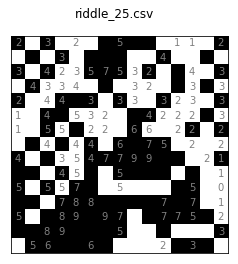

In [6]:
### example usage

# the given file should in the end look like a sitting guy facing to the right
riddle_file = 'riddle_25.csv'
riddle = read_riddle_from_file(riddle_file)

A, b = construct_equations(riddle)
a = np.round(lsq_linear(A, b, (0, 1)).x)

solved_riddle = a.reshape(riddle.shape).astype('int16')

plot_solved_mosaic(riddle, solved_riddle, riddle_file)